# Eksperimen 8: OCR Pipeline (PaddleOCR + Qwen 2.5)

This notebook implements the full pipeline for Experiment 4 using PaddleOCR for text extraction and Qwen 2.5 (3B Instruct) for text correction/refinement.

**Key Improvements:**
- Robust Ollama response parsing.
- Incremental CSV saving to prevent data loss.
- Full dataset processing loop.


In [1]:
# Install required packages
%pip install ollama paddleocr opencv-python numpy pandas matplotlib seaborn

import os
import cv2
import matplotlib.pyplot as plt
import time
import glob
import numpy as np
import pandas as pd
import subprocess
from paddleocr import PaddleOCR
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


c:\projekdosen\tutoring\tutoring-flow\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Checking connectivity to the model hosters, this may take a while. To bypass this check, set `DISABLE_MODEL_SOURCE_CHECK` to `True`.


### DATASET

In [2]:
DATASET_DIR = r'C:\projekdosen\tutoring\Agentic Multimodal Tutor - SLL\dataset\UTS\SOAL2'
IMAGES_DIR = DATASET_DIR
GT_DIR = DATASET_DIR

# ===================== LIMIT PROCESSING =====================
USE_LIMIT = True  # Set to True to limit the number of processed files
LIMIT_COUNT = 50   # Number of files to process if limit is active

### CER

In [3]:
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def calculate_cer(reference, hypothesis):
    if not reference:
        return 0.0
    ref = " ".join(reference.split())
    hyp = " ".join(hypothesis.split())
    return levenshtein_distance(ref, hyp) / len(ref)

### GROUND TRUTH

In [4]:
def read_ground_truth(filename_base):
    path = os.path.join(GT_DIR, f"{filename_base}.txt")
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            return f.read().strip()
    return ""

### OCR INIT

In [5]:
print("Initializing PaddleOCR...")
ocr = PaddleOCR(lang="en", enable_mkldnn=False, use_textline_orientation=True)

Initializing PaddleOCR...


c:\projekdosen\tutoring\tutoring-flow\.venv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:712: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\NUC\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\NUC\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\NUC\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None

### LLM CALL (AMAN)

In [6]:
# ===================== LLM CALL (ROBUST) =====================
def run_llm(prompt):
    # Run subprocess with robust encoding handling
    try:
        result = subprocess.run(
            ["ollama", "run", "qwen2.5:3b-instruct"],
            input=prompt,
            text=True,
            capture_output=True,
            encoding='utf-8',       # Ensure UTF-8 for I/O
            errors='replace'        # Replace chars that fail to encode/decode (fixes charmap error)
        )
        if result.returncode != 0:
            print(f"  [LLM ERROR] Exit Code: {result.returncode}")
            print(f"  [LLM STDERR] {result.stderr[:200]}...") # Print part of stderr
            return None
            
        return result.stdout.strip()
    except Exception as e:
        print(f"  [LLM EXCEPTION] {e}")
        return None


### FILE LIST

In [7]:
image_files = (
    glob.glob(os.path.join(IMAGES_DIR, "*.jpg")) +
    glob.glob(os.path.join(IMAGES_DIR, "*.png")) +
    glob.glob(os.path.join(IMAGES_DIR, "*.jpeg"))
)


results = []

# Apply Limit if Enabled
if USE_LIMIT and LIMIT_COUNT > 0:
    print(f"Limiting processing to first {LIMIT_COUNT} images.")
    image_files = image_files[:LIMIT_COUNT]

print(f"Found {len(image_files)} images.")


Limiting processing to first 50 images.
Found 50 images.


In [8]:
def preprocess_image(image_path, method='none', temp_filename='temp_preprocessed.jpg'):
    img = cv2.imread(image_path)
    if img is None: return None
    
    # 1. Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if method == 'none':
        processed_gray = gray
    elif method == 'clahe':
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        processed_gray = clahe.apply(gray)
    elif method == 'clahe_threshold':
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        _, processed_gray = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        processed_gray = gray

    # 2. Convert back to BGR (3 Channels)
    result = cv2.cvtColor(processed_gray, cv2.COLOR_GRAY2BGR)
    
    # Ensure Abs Path
    abs_temp_path = os.path.abspath(temp_filename)
    
    # Write and Check
    success = cv2.imwrite(abs_temp_path, result)
    if not success:
        print(f"    [ERROR] cv2.imwrite failed for {abs_temp_path}")
        return None
        
    return abs_temp_path


### MAIN LOOP

In [9]:
# Create results directories
os.makedirs(r'results/preprocessed', exist_ok=True)
os.makedirs(r'results/bbox_visualizations', exist_ok=True)

# EXPERIMENT SETTINGS
PREPROCESS_METHODS = ['none', 'clahe', 'clahe_threshold']
results = []

print(f"Starting processing with methods: {PREPROCESS_METHODS}")

for idx, image_path in enumerate(image_files):
    filename = os.path.basename(image_path)
    filename_base = os.path.splitext(filename)[0]
    gt_text = read_ground_truth(filename_base)

    print(f"\nProcessing [{idx+1}/{len(image_files)}]: {filename}...")
    
    for method in PREPROCESS_METHODS:
        print(f"  > Method: {method}")
        start_time = time.time()
        
        # ---------- PREPROCESS & SAVE ----------
        if method == 'none':
            input_path = image_path
            # No extra saving for 'none', it's the original image
        else:
            # Save preprocessed image permanently
            preproc_name = f"{filename_base}_{method}.jpg"
            save_path = os.path.join(r'results/preprocessed', preproc_name)
            
            input_path = preprocess_image(image_path, method=method, temp_filename=save_path)
            if input_path is None:
                input_path = image_path # Fallback

        # ---------- OCR ----------
        try:
             # Using input_path (either original or preprocessed file)
            ocr_result = ocr.predict(input_path)
        except Exception as e:
            print(f"    [OCR ERROR] {e}")
            ocr_result = []
            
        extracted_lines = []
        bboxes = []

        if ocr_result and len(ocr_result) > 0:
            if isinstance(ocr_result[0], dict) and "rec_texts" in ocr_result[0]:
                extracted_lines = ocr_result[0]["rec_texts"]
                if "dt_polys" in ocr_result[0]:
                    bboxes = ocr_result[0]["dt_polys"]
            elif isinstance(ocr_result[0], list):
                for line in ocr_result[0]:
                    if isinstance(line, list) and len(line) >= 2:
                        if isinstance(line[1], (tuple, list)):
                            extracted_lines.append(line[1][0])
                        if isinstance(line[0], list):
                            bboxes.append(line[0])
        
        # ---------- VISUALIZATION (BBOX) ----------
        if bboxes:
            # Load the ACTUAL image used (Preprocessed or Original) to draw on
            img_vis = cv2.imread(input_path)
            if img_vis is not None:
                # Draw each box
                for box in bboxes:
                    box = np.array(box).astype(np.int32).reshape((-1, 1, 2))
                    cv2.polylines(img_vis, [box], True, (0, 0, 255), 2) # Red BBox
                
                # Save Visualization
                vis_name = f"vis_{filename_base}_{method}.jpg"
                vis_path = os.path.join(r'results/bbox_visualizations', vis_name)
                cv2.imwrite(vis_path, img_vis)

        raw_text = "\n".join(extracted_lines)

        # ---------- LLM ----------
        final_text = raw_text
        if raw_text.strip():
            if not os.path.exists("prompt_correction.txt"):
                print("  [ERROR] prompt_correction.txt not found!")
                continue
            with open("prompt_correction.txt", "r", encoding="utf-8") as f:
                prompt = f.read().replace("{OCR_TEXT}", raw_text)

            # print("  [LLM] running...")
            llm_out = run_llm(prompt)

            if llm_out is None:
                final_text = raw_text
            else:
                final_text = (
                    llm_out
                    .replace("```plaintext", "")
                    .replace("```", "")
                    .strip()
                )

        # ---------- METRIC ----------
        elapsed = time.time() - start_time
        cer_raw = calculate_cer(gt_text, raw_text)
        cer_refined = calculate_cer(gt_text, final_text)

        print(
            f"    OCR Len: {len(raw_text)} | "
            f"Raw: {cer_raw:.2%} | "
            f"Refined: {cer_refined:.2%} | "
            f"Time: {elapsed:.2f}s"
        )

        results.append({
            "filename": filename,
            "method": method,
            "time": elapsed,
            "cer_raw": cer_raw,
            "cer_refined": cer_refined,
            "raw_text": raw_text,
            "final_text": final_text,
            "ground_truth": gt_text
        })

    # Save partial results incrementally
    if len(results) > 0:
        pd.DataFrame(results).to_csv('results/exp8_clahe_results.csv', index=False)

print("\nDONE. Total processed results:", len(results))


Starting processing with methods: ['none', 'clahe', 'clahe_threshold']

Processing [1/50]: if4908_103012400180_nomor2.jpg...
  > Method: none
    OCR Len: 217 | Raw: 31.22% | Refined: 39.82% | Time: 69.41s
  > Method: clahe
    OCR Len: 210 | Raw: 32.58% | Refined: 41.18% | Time: 24.70s
  > Method: clahe_threshold
    OCR Len: 191 | Raw: 42.08% | Refined: 45.70% | Time: 32.25s

Processing [2/50]: if4908_103012400221_nomor2.jpg...
  > Method: none
    OCR Len: 93 | Raw: 39.20% | Refined: 22.40% | Time: 19.07s
  > Method: clahe
    OCR Len: 94 | Raw: 36.80% | Refined: 20.80% | Time: 18.82s
  > Method: clahe_threshold
    OCR Len: 90 | Raw: 44.00% | Refined: 26.40% | Time: 17.94s

Processing [3/50]: if4908_103012400283_nomor2.jpg...
  > Method: none
    OCR Len: 134 | Raw: 0.00% | Refined: 0.00% | Time: 22.80s
  > Method: clahe
    OCR Len: 119 | Raw: 0.00% | Refined: 0.00% | Time: 22.57s
  > Method: clahe_threshold
    OCR Len: 62 | Raw: 0.00% | Refined: 0.00% | Time: 18.26s

Processing 


=== METRIC SUMMARY PER METHOD ===
            method   cer_raw  cer_refined       time
0            clahe  0.369591     0.319325  28.235489
1  clahe_threshold  0.423276     0.404905  25.665906
2             none  0.363496     0.341703  28.938794

Overall Average Refined CER (All Methods): 35.53%


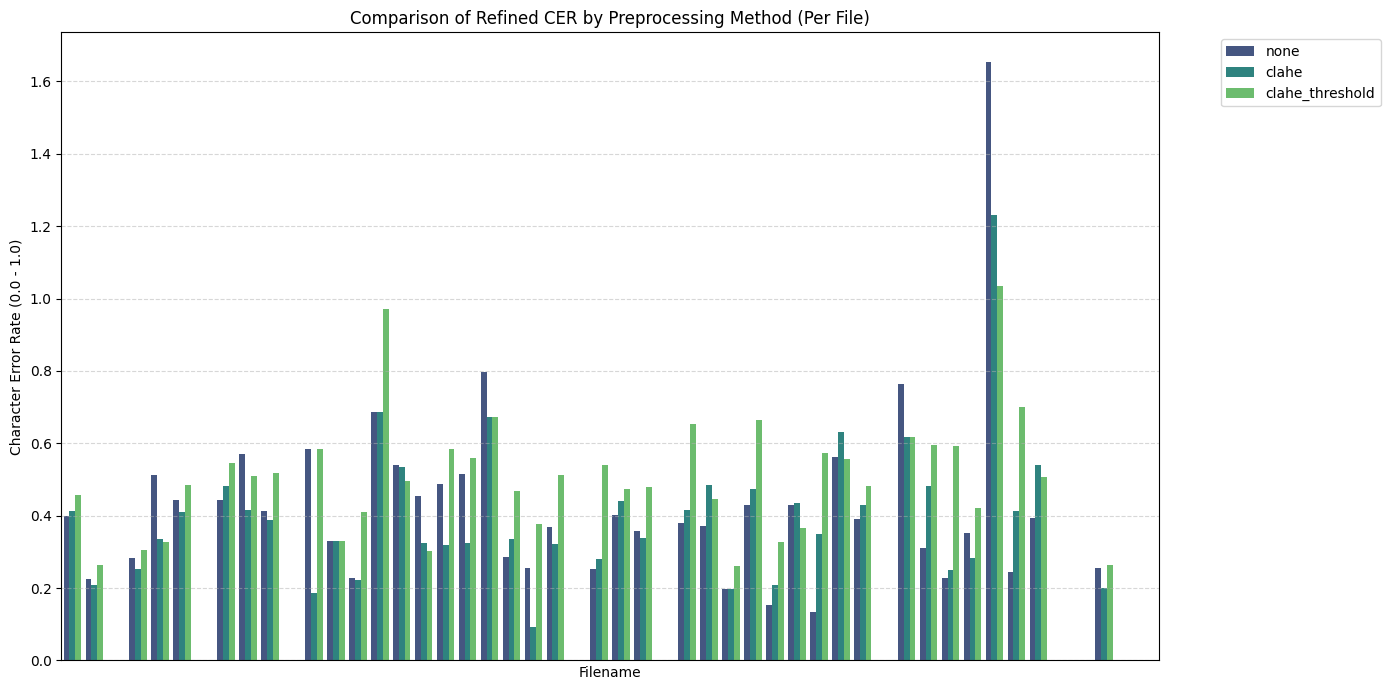

C:\Users\NUC\AppData\Local\Temp\ipykernel_29092\21513483.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='method', y='cer_refined', palette='magma')


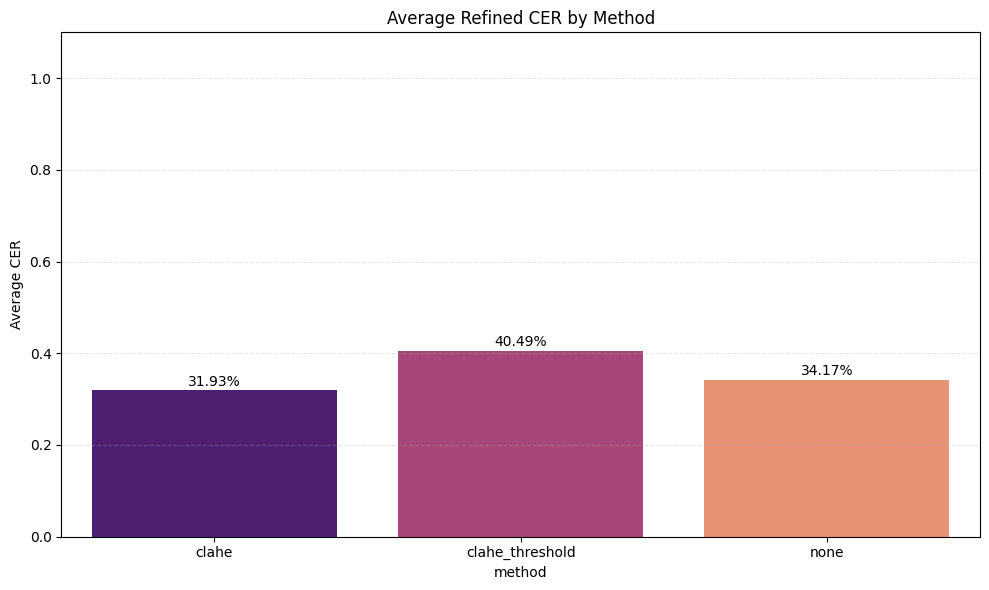

In [11]:
# ===================== VISUALIZE METRICS =====================
if results:
    df = pd.DataFrame(results)
    
    # 1. Summary Metrics per Method
    print("\n=== METRIC SUMMARY PER METHOD ===")
    summary = df.groupby('method')[['cer_raw', 'cer_refined', 'time']].mean().reset_index()
    print(summary)
    
    # 2. Overall Average Refined CER (Across all methods/samples)
    overall_avg_refined = df['cer_refined'].mean()
    print(f"\nOverall Average Refined CER (All Methods): {overall_avg_refined:.2%}")
    
    try:
        # PLOT 1: Refined CER per File (Detailed)
        plt.figure(figsize=(14, 7))
        sns.barplot(data=df, x='filename', y='cer_refined', hue='method', palette='viridis')
        plt.title('Comparison of Refined CER by Preprocessing Method (Per File)')
        plt.xlabel('Filename')
        plt.ylabel('Character Error Rate (0.0 - 1.0)')
        
        if len(df['filename'].unique()) > 20:
            plt.xticks([]) 
        else:
            plt.xticks(rotation=90, ha='right')
        
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig('results/exp8_per_file_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        # PLOT 2: Average Metrics Bar Chart
        plt.figure(figsize=(10, 6))
        
        # Melt for easier sns plotting if comparing raw vs refined, but here we just want Average Refined per Method
        sns.barplot(data=summary, x='method', y='cer_refined', palette='magma')
        
        # Add values on top of bars
        for index, row in summary.iterrows():
            plt.text(index, row.cer_refined + 0.01, f"{row.cer_refined:.2%}", color='black', ha="center")

        plt.title('Average Refined CER by Method')
        plt.ylabel('Average CER')
        plt.ylim(0, 1.1)
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('results/exp8_average_method_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"Error plotting: {e}")
